In [1]:
"""
Load in all the renalsysis products:
    - GODAS
    - SODA3.4.2
    - ORAS5_opa0
Compare SST climatology between sets
Compare MLD/TC depth. get 3 animations of this for all

regional comparisons of heat budget terms

"""

'\nLoad in all the renalsysis products:\n    - GODAS\n    - SODA3.4.2\n    - ORAS5_opa0\nCompare SST climatology between sets\nCompare MLD/TC depth. get 3 animations of this for all\n\nregional comparisons of heat budget terms\n\n'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [3]:
#function to climatology and anomaly for given variable
def component_fn(inp):
    bar = inp.mean('time')
    #clim = inp.groupby('time.month').mean('time')
    dash = inp - bar
    return bar, dash

def diff_T(T):
    dTdt = T.differentiate(coord = 'time',datetime_unit= 's')
    dTdx = T.differentiate('lon') / (110e3 * np.cos(T.lat * np.pi / 180))
    dTdy = T.differentiate('lat') / (110e3 )
    dTdz = (T[:,0] - T[:,-1])/float(T.level[-1])
    return dTdt[:,:-1], dTdx[:,:-1], dTdy[:,:-1], dTdz

def advection(u, v, w, dx, dy, dz):
    uadv = u*dx
    vadv = v*dy
    wadv = w*dz
    return uadv, vadv, wadv


def get_weights(INP):
    weights = INP.level
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'level': INP.level},
                 dims=['level'])
    return thickness_DA

def weighted_avg(inp, weights):
    avg=inp.weighted(weights).mean('level')
    return avg


def get_clim(dict_name):
    dict1={}
    #unpack dict, get climatology, repack
    for key in dict_name.keys():
        var = dict_name[key]
        var = var.groupby('time.month').mean('time')
        dict1[key] = var
    return dict1

In [4]:
#now do the same for ec-earth3
T = xr.open_mfdataset('/home/z5113258/Documents/SODA3.4.2/temp_7/*.nc').temp
U = xr.open_mfdataset('/home/z5113258/Documents/SODA3.4.2/u_7/*.nc').u
V = xr.open_mfdataset('/home/z5113258/Documents/SODA3.4.2/v_7/*.nc').v
Q = xr.open_mfdataset('/home/z5113258/Documents/SODA3.4.2/net_heating/*.nc').net_heating
#get only to 50m
T = T[:,:5]
U = U[:,:5]
V = V[:,:5]
#W = W[:,4]
#now put lat lon of uvw to T
U = U.assign_coords({'lat': T.lat, 'lon': T.lon})
V = V.assign_coords({'lat': T.lat, 'lon': T.lon})
#W = W.assign_coords({'lat': T.lat, 'lon': T.lon})
#rename lev coord to level
T = T.rename({'st_ocean':'level'})
U = U.rename({'st_ocean':'level'})
V = V.rename({'st_ocean':'level'})
#W = W.rename({'lev':'level'})

In [31]:
#now do the same for ec-earth3
T = xr.open_mfdataset('/home/z5113258/Documents/ORAS5/votemper_70/*.nc').votemper
U = xr.open_mfdataset('/home/z5113258/Documents/ORAS5/vozocrte_70/*.nc').vozocrte
V = xr.open_mfdataset('/home/z5113258/Documents/ORAS5/vomecrtn_70/*.nc').vomecrtn
Q = xr.open_mfdataset('/home/z5113258/Documents/ORAS5/sohefldo_surf/*.nc').sohefldo
#get only to 50m
T = T[:,:19]
U = U[:,:19]
V = V[:,:19]
#W = W[:,4]
#now put lat lon of uvw to T
U = U.assign_coords({'lat': T.lat, 'lon': T.lon})
V = V.assign_coords({'lat': T.lat, 'lon': T.lon})
#W = W.assign_coords({'lat': T.lat, 'lon': T.lon})
#rename lev coord to level
T = T.rename({'deptht':'level'})
U = U.rename({'deptht':'level'})
V = V.rename({'deptht':'level'})

T = T.rename({'time_counter':'time'})
U = U.rename({'time_counter':'time'})
V = V.rename({'time_counter':'time'})
Q = Q.rename({'time_counter':'time'})

#W = W.rename({'lev':'level'})

In [32]:
T

,Array,Chunk
Bytes,2.30 GB,4.92 MB
Shape,"(468, 19, 180, 360)","(1, 19, 180, 360)"
Count,1872 Tasks,468 Chunks
Type,float32,numpy.ndarray


In [33]:
#calculate W term
#first get dudx and dvdy
#mask u and v land values
UM = U.fillna(0)
VM = V.fillna(0)

dudx = UM.differentiate(coord = 'lon') / (110e3 * np.cos(U.lat * np.pi / 180))
dvdy = VM.differentiate(coord='lat') / (110e3)


weights = U.level#add a 0m surface layer
wt=np.array([0.])
for i in range(len(weights.values)):
    NW = 2*weights.values[i]-wt[i]
    wt = np.insert(wt,i+1,NW)
thickness = wt[1:]-wt[:-1]
thickness_DA = xr.DataArray(thickness, coords={'level': U.level},
             dims=['level'])
w_list = []
print(thickness_DA.level)


for i, j in enumerate(thickness_DA):
    if i == 0:
        w = (dudx[:,i]*j + dvdy[:,i]*j)
        #add to new DataArray with vertical coords put in
        w = w.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
    else:
        l = (dudx[:,i]*j + dvdy[:,i]*j) + w_list[i-1]
        w = l.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
#now put all layers into one array
w = xr.concat(w_list, dim = 'level')
W=w
W=W[18,:]

<xarray.DataArray 'level' (level: 19)>
array([ 0.50576 ,  1.555855,  2.667682,  3.85628 ,  5.140361,  6.543034,
        8.092519,  9.82275 , 11.77368 , 13.991038, 16.525322, 19.429802,
       22.757616, 26.5583  , 30.874561, 35.740204, 41.180023, 47.211895,
       53.850636], dtype=float32)
Coordinates:
  * level    (level) float32 0.5058 1.556 2.668 3.856 ... 41.18 47.21 53.85
Attributes:
    long_name:  Vertical T levels
    units:      m
    axis:       Z


In [26]:
W[18,:]

<xarray.DataArray (time_counter: 468, lat: 180, lon: 360)>
dask.array<getitem, shape=(468, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1980-01-16 ... 2018-12-16
  * lon           (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat           (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    level         float64 53.85

In [28]:
(W.groupby('time.month').mean('time')[0]- wC[0]).plot(vmin = -1e-13)

KeyError: 'time'

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


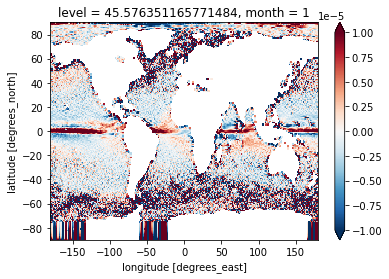

In [83]:
wC[0].plot(vmin = -0.00001)

In [34]:
dTdt, dTdx, dTdy, dTdz = diff_T(T)

ValueError: Chunk size must be larger than edge_order + 1. Minimum chunk for axis 0 is 1. Rechunk to proceed.

In [30]:
qnet = (Q)/(3986*1026*50)

In [67]:
uadv, vadv, wadv = advection(U, V, W, dTdx, dTdy, dTdz)

In [68]:
#calcualate weights of levels
weights = get_weights(T)
#now get wtd avg
dTdt_w = weighted_avg(dTdt, weights)
uw = weighted_avg(uadv, weights)
vw = weighted_avg(vadv, weights)
ww = wadv

In [70]:
#alse get weighted avergae of u cur, v cur, and dtdx and dtdy
#decompose advection terms to see where the bias is coming from - temp or current
#GODAS
dTdxw = weighted_avg(dTdx, weights)
dTdyw = weighted_avg(dTdy, weights)

Uw = weighted_avg(U, weights)
Vw = weighted_avg(V, weights)

In [71]:
#now calcaulte cliamotlogy of terms
dT_c = dTdt_w.groupby('time.month').mean('time')
u_c = uw.groupby('time.month').mean('time')
v_c = vw.groupby('time.month').mean('time')
w_c = ww.groupby('time.month').mean('time')
q_c = qnet.groupby('time.month').mean('time')

In [72]:
dxC = dTdxw.groupby('time.month').mean('time')
dyC = dTdyw.groupby('time.month').mean('time')
dzC = dTdz.groupby('time.month').mean('time')
uC = Uw.groupby('time.month').mean('time')
vC = Vw.groupby('time.month').mean('time')
wC = W.groupby('time.month').mean('time')

In [73]:
def plot_background(ax, i, j):
    #for use with plotting 12 months. need to change 
    ax.set_extent([30., 125., -30., 20.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5,)
    gl.top_labels = False
    gl.right_labels = False
    if i == 5:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    if j > 0:
        gl.left_labels = False
    return ax
def plot_var(vari, vmin, vmax, name):
    lons = vari.lon
    lats = vari.lat
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 15), sharey='all', sharex='all', 
                                 subplot_kw={'projection':ccrs.PlateCarree()})
    for i in range(0,6):

        axes[i, 0].pcolormesh(lons, lats, (vari).sel(month = i+1), cmap = 'RdBu_r', 
                                    vmin = vmin, vmax = vmax, 
                                    transform=ccrs.PlateCarree())
        plot_background(axes[i,0], i, 0)
        mon = i+1
        axes[i, 0].set_title('Month = '+str(mon))
        #2nd collumn
        im = axes[i, 1].pcolormesh(lons, lats, (vari).sel(month = i+7), cmap = 'RdBu_r', 
                                    #colorbar=True, 
                                    vmin = vmin, vmax = vmax, 
                                    transform=ccrs.PlateCarree())
        plot_background(axes[i,1], i, 1)
        mon2 = i+7
        axes[i, 1].set_title('Month = '+str(mon2))
    cbar_ax = fig.add_axes([0.95, 0.45, 0.05, 0.25])
    fig.colorbar(im, cax=cbar_ax)
    axes[0,0].text(1.5,1.3, name, va='bottom', ha='center', fontsize = 'x-large',
            rotation='horizontal', rotation_mode='anchor',
            transform=axes[0,0].transAxes)
    return fig

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.

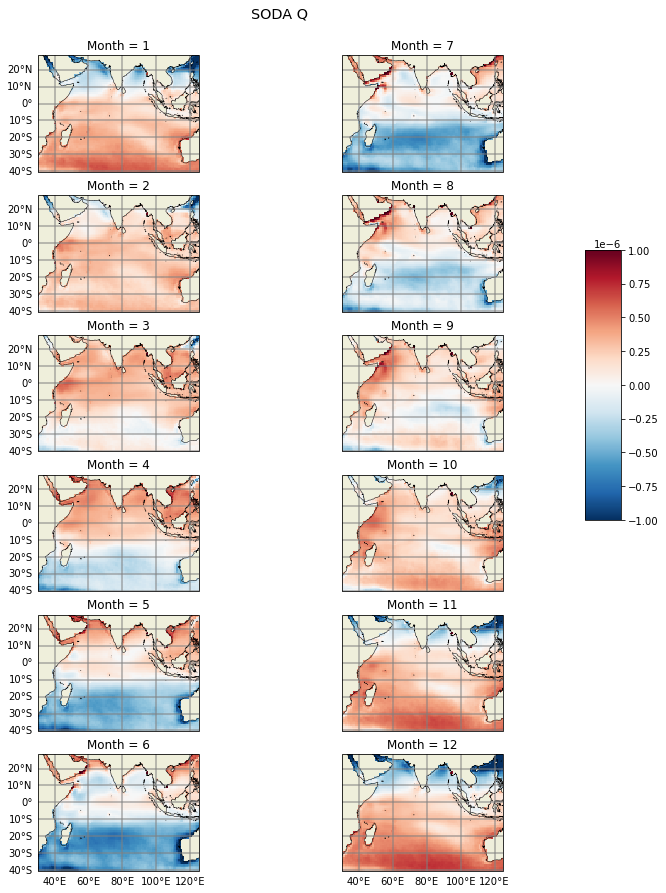

In [97]:
a = plot_var(q_c, -1e-6, 1e-6, 'SODA Q')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.

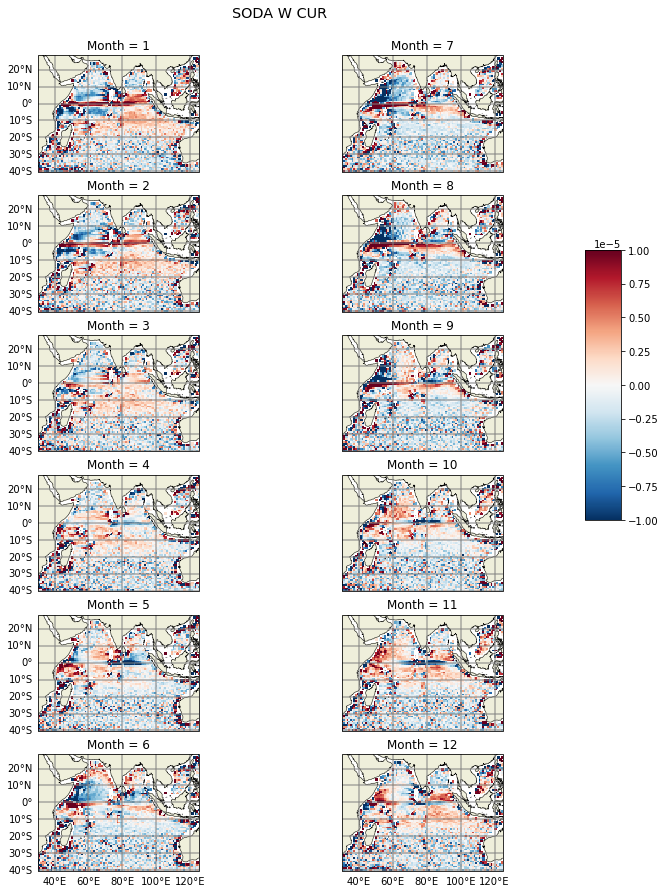

In [77]:
a = plot_var(wC, -1e-5, 1e-5, 'SODA W CUR')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


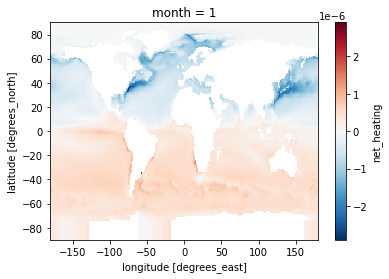

In [96]:
q_c[0].plot()

In [11]:
test = T.interp(level = [5,15,25,35,40,50], method='linear')#interpolates dat onto these new specified le

In [13]:
test

,Array,Chunk
Bytes,765.16 MB,18.66 MB
Shape,"(492, 6, 180, 360)","(12, 6, 180, 360)"
Count,289 Tasks,41 Chunks
Type,float32,numpy.ndarray
